# Install rclone
This is you can save your checkpoint weights to your actual google drive for restoration.

In [1]:
! curl https://rclone.org/install.sh | sudo bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4491  100  4491    0     0   8425      0 --:--:-- --:--:-- --:--:--  8425
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    15  100    15    0     0     53      0 --:--:-- --:--:-- --:--:--    53
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.8M  100 13.8M    0     0  9095k      0  0:00:01  0:00:01 --:--:-- 9089k
Archive:  rclone-current-linux-amd64.zip
   creating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/README.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/rclone.1  [text]  
  inflating:

You want to create a **remote** configuration with rclone.  Use the default recommendations.

In [2]:
!rclone config

2021/06/16 10:00:47 NOTICE: Config file "/root/.config/rclone/rclone.conf" not found - using defaults
No remotes found - make a new one
n) New remote
s) Set configuration password
q) Quit config
n/s/q> n
name> remote
Type of storage to configure.
Enter a string value. Press Enter for the default ("").
Choose a number from below, or type in your own value
 1 / 1Fichier
   \ "fichier"
 2 / Alias for an existing remote
   \ "alias"
 3 / Amazon Drive
   \ "amazon cloud drive"
 4 / Amazon S3 Compliant Storage Providers including AWS, Alibaba, Ceph, Digital Ocean, Dreamhost, IBM COS, Minio, and Tencent COS
   \ "s3"
 5 / Backblaze B2
   \ "b2"
 6 / Box
   \ "box"
 7 / Cache a remote
   \ "cache"
 8 / Citrix Sharefile
   \ "sharefile"
 9 / Compress a remote
   \ "compress"
10 / Dropbox
   \ "dropbox"
11 / Encrypt/Decrypt a remote
   \ "crypt"
12 / Enterprise File Fabric
   \ "filefabric"
13 / FTP Connection
   \ "ftp"
14 / Google Cloud Storage (this is not Google Drive)
   \ "google cloud sto

# 1.0 Purpose
The purpose of this notebook is to explore Time Series datasets with TensorFlow on a variety of neural network architectures using a custom TensorFlow dataset.

# 2.0 Import Libraries

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
tf.__version__

'2.5.0'

## Helper Functions

In [4]:
def plot_series(time, series, format='-',start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [5]:
def trend(time, slope=0):
  return slope*time

In [6]:
def seasonal_pattern(season_time):
  """Just an arbitrary pattern, change if you like"""
  return np.where(season_time <0.2,np.cos(season_time*4*np.pi),
                  2/np.exp(4*season_time))

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
  """Repeats the same pattern at each period"""
  season_time=((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

In [8]:
def noise(time, noise_level=1, seed=None):
  rnd=np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

In [9]:
time=np.arange(4*365+1,dtype='float32')
baseline=10
amplitude=40
slope=0.05
noise_level=5
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
series+=noise(time,noise_level,seed=30)

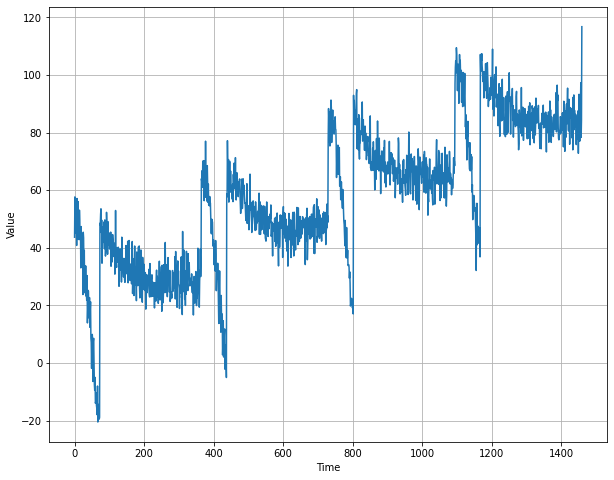

In [10]:
plt.figure(figsize=(10,8))
plot_series(time,series)
plt.show()

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

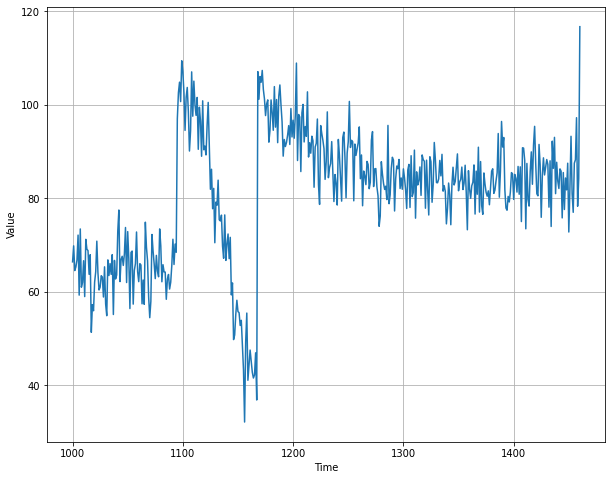

In [12]:
plt.figure(figsize=(10, 8))
plot_series(time_valid, x_valid)


# 3.0 Custom TF Dataset

In [13]:
dataset=tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [14]:
dataset=tf.data.Dataset.range(10)
dataset=dataset.window(5,shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end='')
  print()

01234
12345
23456
34567
45678
56789
6789
789
89
9


In [15]:
dataset=tf.data.Dataset.range(10)
dataset=dataset.window(5,shift=1,drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end='')
  print()

01234
12345
23456
34567
45678
56789


In [16]:
dataset=tf.data.Dataset.range(10)
dataset=dataset.window(5,shift=1,drop_remainder=True)
dataset=dataset.flat_map(lambda window: window.batch(5))
dataset=dataset.map(lambda window: (window[:-1],window[-1:]))
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end='')
  print()

[0 1 2 3][4]
[1 2 3 4][5]
[2 3 4 5][6]
[3 4 5 6][7]
[4 5 6 7][8]
[5 6 7 8][9]


In [17]:
dataset = tf.data.Dataset.range(10)
dataset=dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end=" ")
  print()

[2 3 4 5] [6] 
[4 5 6 7] [8] 
[1 2 3 4] [5] 
[3 4 5 6] [7] 
[0 1 2 3] [4] 
[5 6 7 8] [9] 


In [18]:
dataset = tf.data.Dataset.range(10)
dataset=dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end=" ")
  print()

[[0 1 2 3]
 [3 4 5 6]] [[4]
 [7]] 
[[1 2 3 4]
 [2 3 4 5]] [[5]
 [6]] 
[[4 5 6 7]
 [5 6 7 8]] [[8]
 [9]] 


In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [20]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
dataset=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [22]:
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end=" ")
  print()

[[42.27603  27.873352 34.218143 35.24998  42.53951  31.739824 34.47227
  28.659588 33.743668 29.170633 30.604479 27.529821 30.149448 42.189133
  24.138641 29.071848 36.15313  26.691742 23.44905  31.041359]
 [31.086512 35.451622 27.92527  31.997986 27.279911 25.982191 18.949423
  27.009314 24.399393 26.39296  26.79614  36.853676 22.72534  24.398685
  16.842659 45.672424 24.76256  36.59232  26.514929 39.21092 ]
 [70.43862  69.270294 57.37191  61.88068  67.75419  66.369576 64.0931
  64.1592   67.70692  62.08566  67.862526 78.13584  76.28375  66.078064
  68.97234  68.7485   58.696323 66.970245 59.572292 64.00818 ]
 [42.834126 53.06206  49.335503 43.454872 46.884068 33.042362 47.38177
  41.857372 38.70566  38.04922  44.57351  23.787754 45.41041  43.44397
  31.953457 39.134785 24.612785 26.494135 24.272087 33.735394]
 [57.00302  41.926056 44.01287  43.839542 54.235664 48.184483 49.968464
  53.11909  43.25171  48.23754  51.395397 44.682777 45.173058 46.320126
  42.32309  50.340866 47.487362 4

# 4.0 models

In [23]:
cols=['filename','model_name','model_description',
      'optimizer',
      'loss','epochs','mae_valid']
df_metrics=pd.DataFrame(columns=cols)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid


## 4.1 model1

In [24]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model1'
model_description='Dense ANN with 10 neurons for first two layers, relu activation, final output layer is Dense(1)'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)
optimizer_name=str(optimizer)
loss_name='mse'
epochs=100

In [25]:
model1=tf.keras.models.Sequential([
                                  tf.keras.layers.Dense(10,input_shape=[window_size],activation='relu'),
                                  tf.keras.layers.Dense(10, activation='relu'),
                                  tf.keras.layers.Dense(1)
])

In [26]:
model1.compile(loss=loss_name,optimizer=optimizer)

In [27]:
history1=model1.fit(dataset,epochs=epochs,verbose=1)

Epoch 1/100
31/31 [==============================] - 2s 4ms/step - loss: 1409.4631
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 128.5608
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 98.9549
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 92.3282
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 88.7453
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 85.2706
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 83.0799
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 80.4890
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 78.7911
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 77.3724
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 75.7776
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 73.9477
Epoch 13/100
31/31 [==

In [28]:
history1.history.keys()

dict_keys(['loss'])

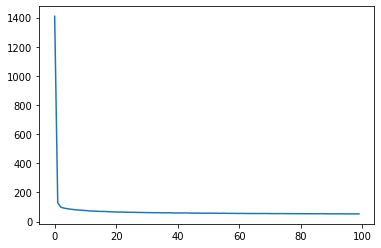

In [29]:
plt.plot(history1.history['loss'])

In [30]:
forecast=[]
for time in range(len(series)-window_size):
  forecast.append(model1.predict(series[time:time + window_size][np.newaxis]))

In [31]:
np.zeros(shape=(1,1)).shape

(1, 1)

In [32]:
np.zeros(shape=(1,1))[np.newaxis].shape

(1, 1, 1)

In [33]:
split_time

1000

In [34]:
forecast=forecast[split_time-window_size:]
forecast

[array([[64.13528]], dtype=float32),
 array([[62.987846]], dtype=float32),
 array([[66.0028]], dtype=float32),
 array([[64.167114]], dtype=float32),
 array([[63.267868]], dtype=float32),
 array([[66.95396]], dtype=float32),
 array([[70.94419]], dtype=float32),
 array([[64.22805]], dtype=float32),
 array([[67.11828]], dtype=float32),
 array([[64.023415]], dtype=float32),
 array([[63.598167]], dtype=float32),
 array([[63.073196]], dtype=float32),
 array([[64.573364]], dtype=float32),
 array([[64.11061]], dtype=float32),
 array([[66.42935]], dtype=float32),
 array([[66.62078]], dtype=float32),
 array([[66.49143]], dtype=float32),
 array([[65.82227]], dtype=float32),
 array([[60.00612]], dtype=float32),
 array([[58.78477]], dtype=float32),
 array([[55.55034]], dtype=float32),
 array([[57.724346]], dtype=float32),
 array([[62.146866]], dtype=float32),
 array([[63.419147]], dtype=float32),
 array([[64.83817]], dtype=float32),
 array([[63.15641]], dtype=float32),
 array([[59.238434]], dtype=f

In [35]:
results=np.array(forecast)[:,0,0]

In [36]:
results

array([ 64.13528 ,  62.987846,  66.0028  ,  64.167114,  63.267868,
        66.95396 ,  70.94419 ,  64.22805 ,  67.11828 ,  64.023415,
        63.598167,  63.073196,  64.573364,  64.11061 ,  66.42935 ,
        66.62078 ,  66.49143 ,  65.82227 ,  60.00612 ,  58.78477 ,
        55.55034 ,  57.724346,  62.146866,  63.419147,  64.83817 ,
        63.15641 ,  59.238434,  62.38182 ,  62.82448 ,  61.390587,
        62.546043,  63.603844,  56.462795,  59.666046,  60.902473,
        61.982574,  61.362385,  66.41752 ,  62.978893,  63.457924,
        62.502136,  64.431175,  64.796425,  71.531044,  70.203285,
        66.33492 ,  65.29126 ,  67.93908 ,  65.52721 ,  68.30233 ,
        68.2117  ,  70.26568 ,  65.750626,  64.86141 ,  61.826683,
        64.48008 ,  62.75759 ,  63.50075 ,  62.234245,  69.981995,
        66.989   ,  61.31419 ,  63.865646,  67.14428 ,  59.688385,
        62.897404,  59.882133,  64.160904,  67.9085  ,  67.405205,
        61.45874 ,  59.74223 ,  57.0055  ,  64.202644,  65.322

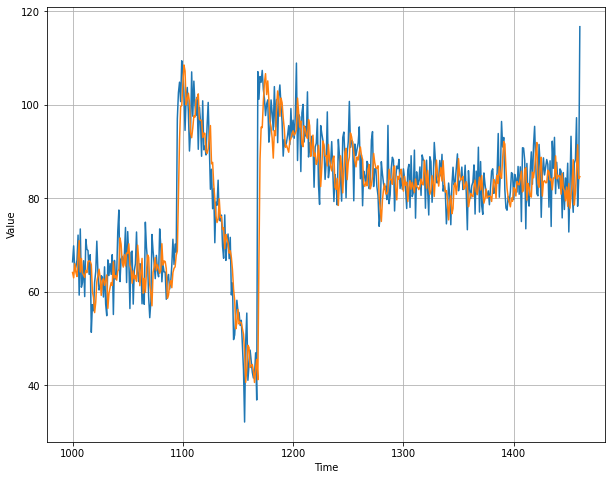

In [37]:
plt.figure(figsize=(10,8))
plot_series(time_valid,x_valid)
plot_series(time_valid,results)

In [38]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

5.2591567

In [39]:
df_metrics.columns

Index(['filename', 'model_name', 'model_description', 'optimizer', 'loss',
       'epochs', 'mae_valid'],
      dtype='object')

In [40]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.259157


In [41]:
model1.save(model_name) #save model
model1=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model1/assets


## 4.2 model2

In [42]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model2'
model_description='Learning Rate scheduler, Dense ANN with 10 neurons for first two layers, relu activation, final output layer is Dense(1)'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='mse'
epochs=100

In [43]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model2.compile(loss=loss_name, optimizer=optimizer)
history2 = model2.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 1991.6986
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 1909.7963
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 1804.3159
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 1676.5540
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 1521.6926
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 1336.1796
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 1119.3408
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 875.8384
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 627.1396
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 406.7759
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 248.8173
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 164.9974
Epoch 

(1e-08, 0.001, 0.0, 300.0)

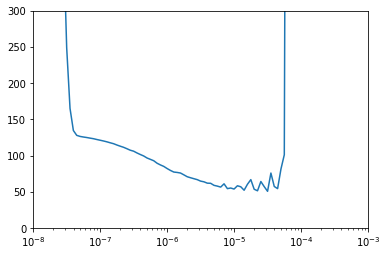

In [44]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history2.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

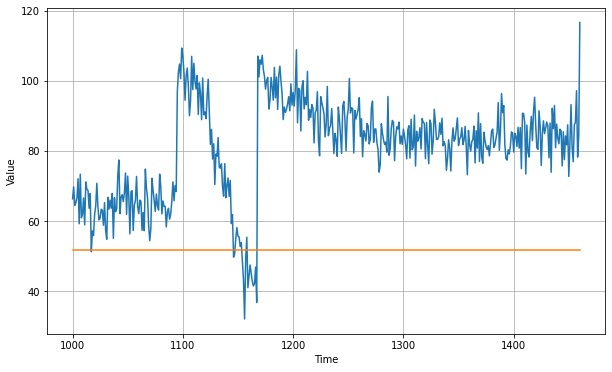

In [45]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model2.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [46]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

29.332115

In [47]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.259157
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.332115


In [48]:
model2.save(model_name) #save model
model2=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model2/assets


## 4.3 model3

In [49]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model3'
model_description='window size = 30, Learning Rate scheduler, Dense ANN with 10 neurons for first two layers, relu activation, final output layer is Dense(1)'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='mse'
epochs=500

In [50]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model3 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

model3.compile(loss=loss_name, optimizer=optimizer)
history3 = model3.fit(dataset, epochs=epochs, verbose=1)

Epoch 1/500
31/31 [==============================] - 1s 3ms/step - loss: 893.6125
Epoch 2/500
31/31 [==============================] - 0s 2ms/step - loss: 296.2837
Epoch 3/500
31/31 [==============================] - 0s 2ms/step - loss: 148.7103
Epoch 4/500
31/31 [==============================] - 0s 2ms/step - loss: 125.8109
Epoch 5/500
31/31 [==============================] - 0s 2ms/step - loss: 122.1421
Epoch 6/500
31/31 [==============================] - 0s 2ms/step - loss: 121.4606
Epoch 7/500
31/31 [==============================] - 0s 2ms/step - loss: 121.1779
Epoch 8/500
31/31 [==============================] - 0s 2ms/step - loss: 120.9507
Epoch 9/500
31/31 [==============================] - 0s 2ms/step - loss: 120.7035
Epoch 10/500
31/31 [==============================] - 0s 2ms/step - loss: 120.4358
Epoch 11/500
31/31 [==============================] - 0s 2ms/step - loss: 120.1897
Epoch 12/500
31/31 [==============================] - 0s 2ms/step - loss: 119.9624
Epoch 13/500


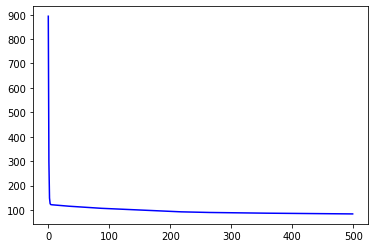

In [51]:
loss = history3.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[120.18965911865234, 119.96238708496094, 119.76173400878906, 119.5201187133789, 119.2855224609375, 119.0811996459961, 118.88423919677734, 118.6649398803711, 118.5264892578125, 118.23014831542969, 118.0676040649414, 117.80247497558594, 117.62866973876953, 117.41582489013672, 117.18775939941406, 117.00872802734375, 116.8019790649414, 116.60320281982422, 116.39786529541016, 116.19892120361328, 116.0206527709961, 115.91822814941406, 115.68708801269531, 115.44955444335938, 115.26792907714844, 115.0980453491211, 114.8822250366211, 114.717529296875, 114.54943084716797, 114.38020324707031, 114.21668243408203, 114.04369354248047, 113.82296752929688, 113.6529769897461, 113.47207641601562, 113.30949401855469, 113.22235107421875, 112.95680236816406, 112.79194641113281, 112.63252258300781, 112.49871826171875, 112.2900161743164, 112.14149475097656, 111.91691589355469, 111.7563247680664, 111.64999389648438, 111.41548156738281, 111.2539291381836, 111.13501739501953, 110.9029312133789, 110.824882507324

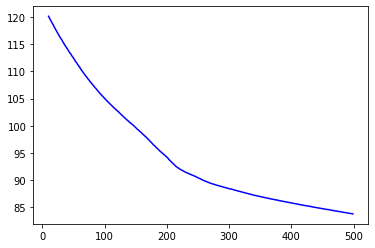

In [52]:
# Plot all but the first 10
loss = history3.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

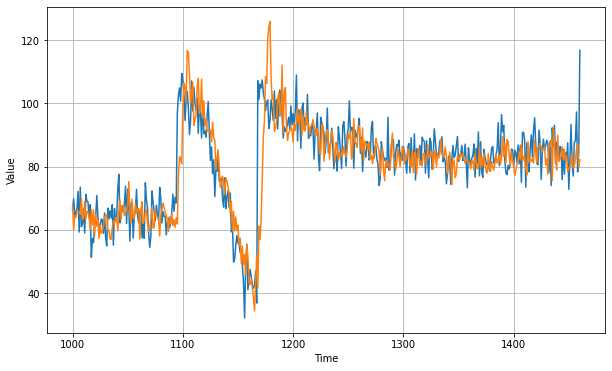

In [53]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model3.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [54]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

6.081384

In [55]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.259157
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.332115
2,TF_TimeSeries_Custom_TFDataset.ipynb,model3,"window size = 30, Learning Rate scheduler, Den...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",6.081384


In [56]:
model3.save(model_name) #save model
model3=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model3/assets


In [57]:
model3.save(model_name) #save model
model3=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model3/assets


## 4.4 model4

In [58]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model4'
model_description='SimpleRNN'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='huber'
epochs=100

In [59]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model4 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model4.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history4 = model4.fit(train_set, epochs=epochs, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 56ms/step - loss: 199.4409 - mae: 199.9409
Epoch 2/100
8/8 [==============================] - 1s 56ms/step - loss: 198.6510 - mae: 199.1510
Epoch 3/100
8/8 [==============================] - 1s 53ms/step - loss: 197.3745 - mae: 197.8745
Epoch 4/100
8/8 [==============================] - 1s 54ms/step - loss: 195.7692 - mae: 196.2692
Epoch 5/100
8/8 [==============================] - 1s 53ms/step - loss: 193.8704 - mae: 194.3704
Epoch 6/100
8/8 [==============================] - 1s 54ms/step - loss: 191.6908 - mae: 192.1903
Epoch 7/100
8/8 [==============================] - 1s 54ms/step - loss: 189.1921 - mae: 189.6921
Epoch 8/100
8/8 [==============================] - 1s 51ms/step - loss: 186.3356 - mae: 186.8356
Epoch 9/100
8/8 [==============================] - 1s 54ms/step - loss: 183.0578 - mae: 183.5578
Epoch 10/100
8/8 [==============================] - 1s 54ms/step - loss: 179.2714 - mae: 179.7714
Epoch 11/100
8/8 [===========

(1e-08, 0.0001, 0.0, 30.0)

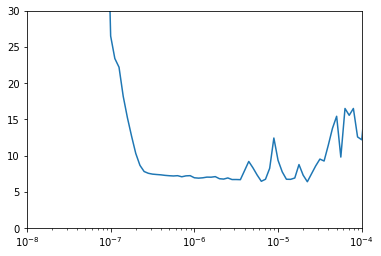

In [60]:
plt.semilogx(history4.history["lr"], history4.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

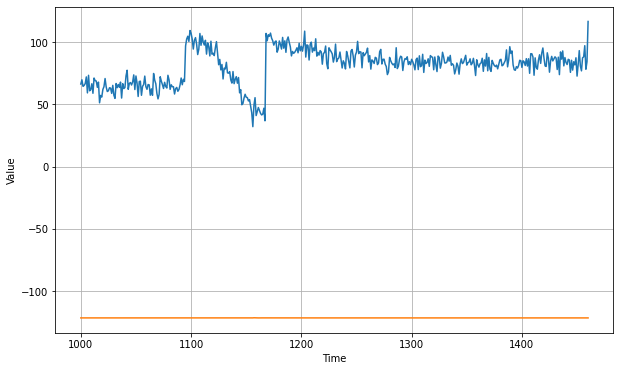

In [61]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model4.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [62]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

202.333

In [63]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.259157
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.332115
2,TF_TimeSeries_Custom_TFDataset.ipynb,model3,"window size = 30, Learning Rate scheduler, Den...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",6.081384
3,TF_TimeSeries_Custom_TFDataset.ipynb,model4,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,202.332993


In [64]:
model4.save(model_name) #save model
model4=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model4/assets


## 4.5 model5

In [65]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model5'
model_description='SimpleRNN'
optimizer=tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='huber'
epochs=400

In [66]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model5 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model5.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history5 = model5.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 53ms/step - loss: 85.0093 - mae: 85.5091
Epoch 2/400
8/8 [==============================] - 1s 53ms/step - loss: 21.6028 - mae: 22.0977
Epoch 3/400
8/8 [==============================] - 1s 52ms/step - loss: 15.0209 - mae: 15.5124
Epoch 4/400
8/8 [==============================] - 1s 53ms/step - loss: 12.6630 - mae: 13.1557
Epoch 5/400
8/8 [==============================] - 1s 54ms/step - loss: 11.9033 - mae: 12.3954
Epoch 6/400
8/8 [==============================] - 1s 53ms/step - loss: 12.3892 - mae: 12.8807
Epoch 7/400
8/8 [==============================] - 1s 55ms/step - loss: 14.9947 - mae: 15.4889
Epoch 8/400
8/8 [==============================] - 1s 55ms/step - loss: 10.3484 - mae: 10.8401
Epoch 9/400
8/8 [==============================] - 1s 56ms/step - loss: 8.9702 - mae: 9.4562
Epoch 10/400
8/8 [==============================] - 1s 55ms/step - loss: 12.1825 - mae: 12.6751
Epoch 11/400
8/8 [==============================] -

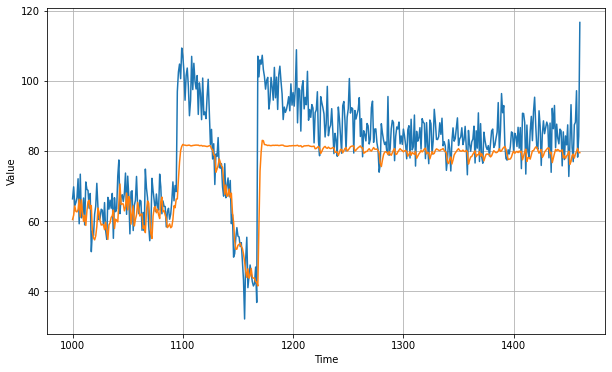

In [67]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model5.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [68]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

7.775039

In [69]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.259157
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.332115
2,TF_TimeSeries_Custom_TFDataset.ipynb,model3,"window size = 30, Learning Rate scheduler, Den...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",6.081384
3,TF_TimeSeries_Custom_TFDataset.ipynb,model4,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,202.332993
4,TF_TimeSeries_Custom_TFDataset.ipynb,model5,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,400,7.775039


In [70]:
model5.save(model_name) #save model
model5=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model5/assets


## 4.6 model6

In [71]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model6'
model_description='Bidirectional LSTM'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='huber'
epochs=100

In [72]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model6 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model6.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history6 = model6.fit(dataset, epochs=epochs, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 8s 11ms/step - loss: 23.8937 - mae: 24.3877
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 23.4584 - mae: 23.9512
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 22.9475 - mae: 23.4413
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 22.4075 - mae: 22.8994
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 21.7920 - mae: 22.2850
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 20.9619 - mae: 21.4539
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 19.4063 - mae: 19.9030
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 18.7229 - mae: 19.2187
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 18.3792 - mae: 18.8738
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 18.0272 - mae: 18.5213
Epoch 11/100
31/31 [=========

(1e-08, 0.0001, 0.0, 30.0)

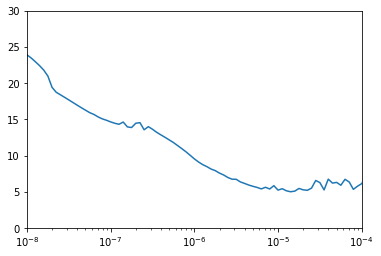

In [73]:
plt.semilogx(history6.history["lr"], history6.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

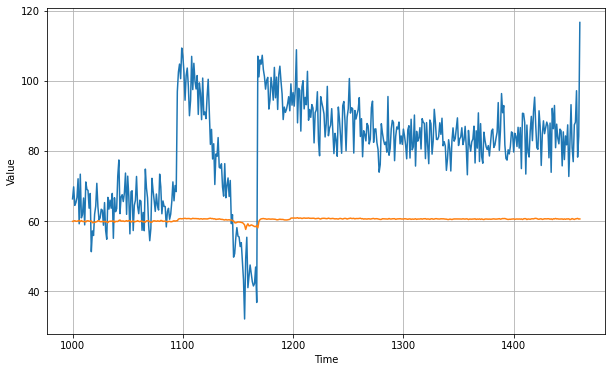

In [74]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model6.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [75]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

21.581238

In [76]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.259157
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.332115
2,TF_TimeSeries_Custom_TFDataset.ipynb,model3,"window size = 30, Learning Rate scheduler, Den...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",6.081384
3,TF_TimeSeries_Custom_TFDataset.ipynb,model4,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,202.332993
4,TF_TimeSeries_Custom_TFDataset.ipynb,model5,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,400,7.775039
5,TF_TimeSeries_Custom_TFDataset.ipynb,model6,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,21.581238


In [77]:
model6.save(model_name) #save model
model6=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


## 4.7 model7

In [78]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model7'
model_description='Bidirectional LSTM'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='mse'
epochs=500

In [79]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model7 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model7.compile(loss=loss_name, optimizer=optimizer,metrics=["mae"])
history7 = model7.fit(dataset,epochs=epochs,verbose=1)

Epoch 1/500
31/31 [==============================] - 7s 11ms/step - loss: 1168.2003 - mae: 27.2400
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 186.1538 - mae: 10.2254
Epoch 3/500
31/31 [==============================] - 0s 11ms/step - loss: 158.3026 - mae: 9.8830
Epoch 4/500
31/31 [==============================] - 0s 12ms/step - loss: 143.8494 - mae: 9.3842
Epoch 5/500
31/31 [==============================] - 0s 11ms/step - loss: 176.6681 - mae: 10.3106
Epoch 6/500
31/31 [==============================] - 0s 11ms/step - loss: 138.2793 - mae: 9.1449
Epoch 7/500
31/31 [==============================] - 0s 11ms/step - loss: 144.1900 - mae: 9.4165
Epoch 8/500
31/31 [==============================] - 0s 11ms/step - loss: 118.6034 - mae: 8.3455
Epoch 9/500
31/31 [==============================] - 0s 11ms/step - loss: 80.0191 - mae: 6.5121
Epoch 10/500
31/31 [==============================] - 0s 12ms/step - loss: 90.5829 - mae: 7.1237
Epoch 11/500
31/31 [=======

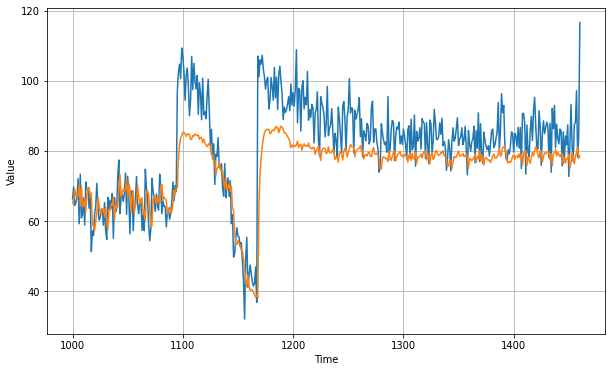

In [80]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model7.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [81]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

7.602301

In [82]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.259157
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.332115
2,TF_TimeSeries_Custom_TFDataset.ipynb,model3,"window size = 30, Learning Rate scheduler, Den...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",6.081384
3,TF_TimeSeries_Custom_TFDataset.ipynb,model4,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,202.332993
4,TF_TimeSeries_Custom_TFDataset.ipynb,model5,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,400,7.775039
5,TF_TimeSeries_Custom_TFDataset.ipynb,model6,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,21.581238
6,TF_TimeSeries_Custom_TFDataset.ipynb,model7,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,mse,500,7.602301


In [83]:
model7.save(model_name) #save model
model7=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


## 4.8 model8

In [84]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model8'
model_description='Multiple Layer Bidirectional LSTM'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='mse'
epochs=100

In [85]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model8 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model8.compile(loss="mse", optimizer=optimizer)
model8.fit(dataset,epochs=epochs)

Epoch 1/100
31/31 [==============================] - 9s 15ms/step - loss: 1113.5515
Epoch 2/100
31/31 [==============================] - 1s 15ms/step - loss: 264.4112
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 179.5178
Epoch 4/100
31/31 [==============================] - 1s 15ms/step - loss: 217.4770
Epoch 5/100
31/31 [==============================] - 1s 15ms/step - loss: 255.3786
Epoch 6/100
31/31 [==============================] - 1s 15ms/step - loss: 178.2136
Epoch 7/100
31/31 [==============================] - 1s 15ms/step - loss: 159.3602
Epoch 8/100
31/31 [==============================] - 1s 15ms/step - loss: 234.9741
Epoch 9/100
31/31 [==============================] - 1s 15ms/step - loss: 296.9833
Epoch 10/100
31/31 [==============================] - 1s 15ms/step - loss: 202.7573
Epoch 11/100
31/31 [==============================] - 1s 15ms/step - loss: 103.1890
Epoch 12/100
31/31 [==============================] - 1s 15ms/step - loss: 95.0204
E

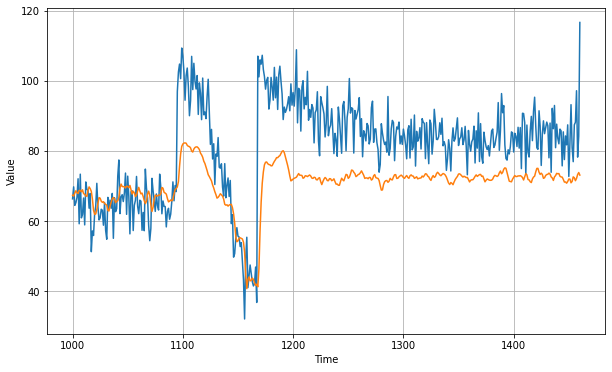

In [86]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model8.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [87]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

11.9768715

In [88]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.259157
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.332115
2,TF_TimeSeries_Custom_TFDataset.ipynb,model3,"window size = 30, Learning Rate scheduler, Den...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",6.081384
3,TF_TimeSeries_Custom_TFDataset.ipynb,model4,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,202.332993
4,TF_TimeSeries_Custom_TFDataset.ipynb,model5,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,400,7.775039
5,TF_TimeSeries_Custom_TFDataset.ipynb,model6,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,21.581238
6,TF_TimeSeries_Custom_TFDataset.ipynb,model7,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,mse,500,7.602301
7,TF_TimeSeries_Custom_TFDataset.ipynb,model8,Multiple Layer Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,11.976871


In [89]:
model8.save(model_name) #save model
model8=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model8/assets


INFO:tensorflow:Assets written to: model8/assets


## 4.9 model9

In [90]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model9'
model_description='Input Conv1D causual padding, 2 layers LSTMs, 3 layers Dense'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='huber'
epochs=100

In [94]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model9 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = optimizer
model9.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history9 = model9.fit(train_set, epochs=epochs, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
(1000,)
Epoch 1/100
4/4 [==============================] - 16s 23ms/step - loss: 53.8566 - mae: 54.3560
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 53.4813 - mae: 53.9807
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 53.0321 - mae: 53.5315
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 52.4540 - mae: 52.9534
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 51.6808 - mae: 52.1801
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 50.7262 - mae: 51.2255
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 49.6236 - mae: 50.1229
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 48.3255 - mae: 48.8248
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 46.7660 - mae: 47.2652
Epoch 10/100
4/4 [==============================] - 0

(1e-08, 0.0001, 0.0, 60.0)

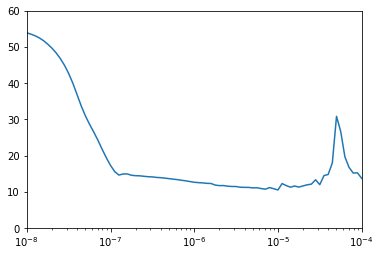

In [95]:
plt.semilogx(history9.history["lr"], history9.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

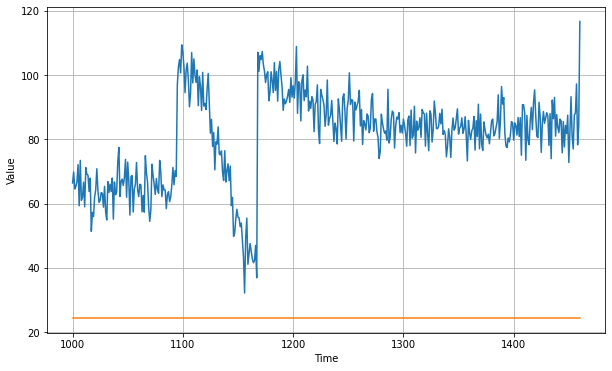

In [96]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model9.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [97]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

array([56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36454,
       56.36454, 56.36454, 56.36454, 56.36454, 56.36454, 56.36

In [98]:
rnn_forecast = model_forecast(model9, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

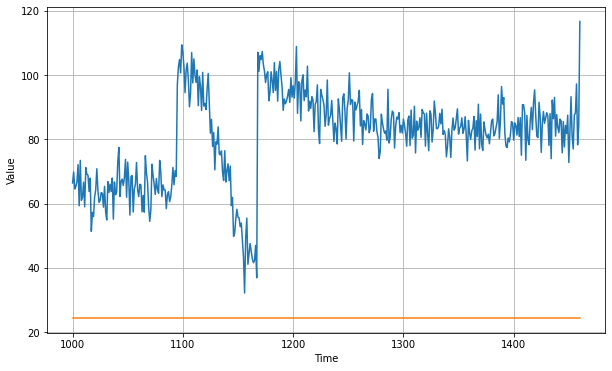

In [99]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [108]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
mae_valid

56.364544

In [109]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.25916
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.3321
2,TF_TimeSeries_Custom_TFDataset.ipynb,model3,"window size = 30, Learning Rate scheduler, Den...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",6.08138
3,TF_TimeSeries_Custom_TFDataset.ipynb,model4,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,202.333
4,TF_TimeSeries_Custom_TFDataset.ipynb,model5,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,400,7.77504
5,TF_TimeSeries_Custom_TFDataset.ipynb,model6,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,21.5812
6,TF_TimeSeries_Custom_TFDataset.ipynb,model7,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,mse,500,7.6023
7,TF_TimeSeries_Custom_TFDataset.ipynb,model8,Multiple Layer Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,11.9769
8,TF_TimeSeries_Custom_TFDataset.ipynb,model10,"Input Conv1D causual padding, 2 layers LSTMs, ...",<tensorflow.python.keras.optimizer_v2.gradient...,huber,500,56.3645


In [110]:
model9.save(model_name) #save model
model9=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model10/assets


INFO:tensorflow:Assets written to: model10/assets


## 4.10 model10

In [103]:
filename='TF_TimeSeries_Custom_TFDataset.ipynb'
model_name='model10'
model_description='Input Conv1D causual padding, 2 layers LSTMs, 3 layers Dense; more filters and epochs; learning rate picked from model9'
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
optimizer_name=str(optimizer)
loss_name='huber'
epochs=500

In [112]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model10 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = optimizer
model10.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history10 = model10.fit(train_set,epochs=epochs)

Epoch 1/500
10/10 [==============================] - 4s 12ms/step - loss: 23.2705 - mae: 23.7659
Epoch 2/500
10/10 [==============================] - 0s 12ms/step - loss: 14.3378 - mae: 14.8288
Epoch 3/500
10/10 [==============================] - 0s 11ms/step - loss: 13.3380 - mae: 13.8289
Epoch 4/500
10/10 [==============================] - 0s 12ms/step - loss: 12.4413 - mae: 12.9293
Epoch 5/500
10/10 [==============================] - 0s 12ms/step - loss: 11.5385 - mae: 12.0247
Epoch 6/500
10/10 [==============================] - 0s 11ms/step - loss: 11.1701 - mae: 11.6556
Epoch 7/500
10/10 [==============================] - 0s 12ms/step - loss: 10.9264 - mae: 11.4105
Epoch 8/500
10/10 [==============================] - 0s 12ms/step - loss: 10.8839 - mae: 11.3690
Epoch 9/500
10/10 [==============================] - 0s 11ms/step - loss: 10.7360 - mae: 11.2214
Epoch 10/500
10/10 [==============================] - 0s 12ms/step - loss: 10.6202 - mae: 11.1042
Epoch 11/500
10/10 [=========

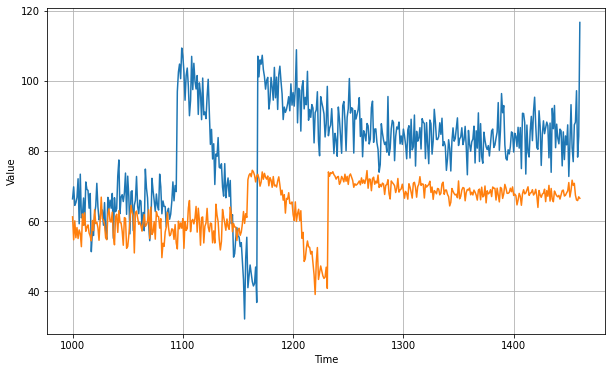

In [113]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model10.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [114]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
mae_valid

array([21.083437 , 26.706835 , 22.016014 , 26.170948 , 23.616806 ,
       26.368504 , 24.204248 , 25.123222 , 28.518269 , 20.402025 ,
       23.092884 , 20.167017 , 24.53477  , 23.489763 , 22.97332  ,
       24.945223 , 25.76627  , 26.984724 , 21.93217  , 24.361803 ,
       19.502972 , 22.652687 , 22.376696 , 23.662523 , 26.833796 ,
       21.941643 , 17.039389 , 21.495754 , 21.860123 , 22.902496 ,
       26.192772 , 26.680243 , 20.57701  , 19.308329 , 22.153553 ,
       22.29299  , 20.020409 , 25.696081 , 28.018652 , 21.039898 ,
       20.48193  , 24.807247 , 19.690393 , 22.43433  , 22.49625  ,
       24.505224 , 28.140188 , 21.248571 , 21.43678  , 28.954342 ,
       28.472216 , 25.583624 , 21.876589 , 18.57549  , 19.989944 ,
       20.881914 , 30.187181 , 20.191175 , 19.77511  , 21.30346  ,
       22.826841 , 22.353868 , 23.147017 , 24.498035 , 22.31605  ,
       20.540323 , 23.324186 , 22.91971  , 22.10431  , 19.49406  ,
       26.341284 , 18.938457 , 25.331463 , 24.750416 , 22.1892

In [115]:
rnn_forecast = model_forecast(model10, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

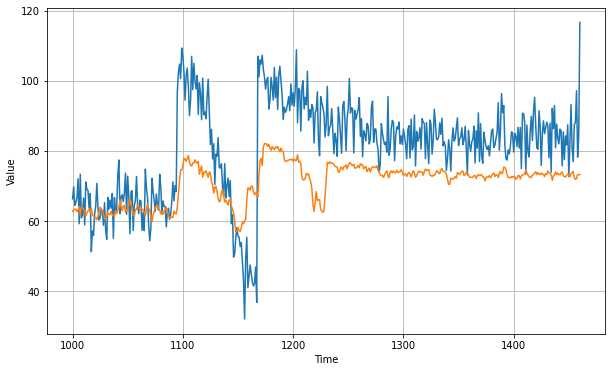

In [116]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [117]:
mae_valid=tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
mae_valid

11.801925

In [118]:
df=pd.DataFrame([[filename,model_name,model_description,optimizer,loss_name,epochs,mae_valid]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,model_description,optimizer,loss,epochs,mae_valid
0,TF_TimeSeries_Custom_TFDataset.ipynb,model1,Dense ANN with 10 neurons for first two layers...,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,5.25916
1,TF_TimeSeries_Custom_TFDataset.ipynb,model2,"Learning Rate scheduler, Dense ANN with 10 neu...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,29.3321
2,TF_TimeSeries_Custom_TFDataset.ipynb,model3,"window size = 30, Learning Rate scheduler, Den...",<tensorflow.python.keras.optimizer_v2.gradient...,mse,"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",6.08138
3,TF_TimeSeries_Custom_TFDataset.ipynb,model4,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,202.333
4,TF_TimeSeries_Custom_TFDataset.ipynb,model5,SimpleRNN,<tensorflow.python.keras.optimizer_v2.gradient...,huber,400,7.77504
5,TF_TimeSeries_Custom_TFDataset.ipynb,model6,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,huber,100,21.5812
6,TF_TimeSeries_Custom_TFDataset.ipynb,model7,Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,mse,500,7.6023
7,TF_TimeSeries_Custom_TFDataset.ipynb,model8,Multiple Layer Bidirectional LSTM,<tensorflow.python.keras.optimizer_v2.gradient...,mse,100,11.9769
8,TF_TimeSeries_Custom_TFDataset.ipynb,model10,"Input Conv1D causual padding, 2 layers LSTMs, ...",<tensorflow.python.keras.optimizer_v2.gradient...,huber,500,56.3645
9,TF_TimeSeries_Custom_TFDataset.ipynb,model10,"Input Conv1D causual padding, 2 layers LSTMs, ...",<tensorflow.python.keras.optimizer_v2.gradient...,huber,500,11.8019


In [119]:
model10.save(model_name) #save model
model10=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model10/assets


INFO:tensorflow:Assets written to: model10/assets


# 5.0 Export Models

In [120]:
!zip -r /content/model1.zip /content/model1
!zip -r /content/model2.zip /content/model2
!zip -r /content/model3.zip /content/model3
!zip -r /content/model4.zip /content/model4
!zip -r /content/model5.zip /content/model5
!zip -r /content/model6.zip /content/model6
!zip -r /content/model7.zip /content/model7
!zip -r /content/model8.zip /content/model8
!zip -r /content/model9.zip /content/model9
!zip -r /content/model10.zip /content/model10

  adding: content/model1/ (stored 0%)
  adding: content/model1/keras_metadata.pb (deflated 88%)
  adding: content/model1/variables/ (stored 0%)
  adding: content/model1/variables/variables.index (deflated 61%)
  adding: content/model1/variables/variables.data-00000-of-00001 (deflated 43%)
  adding: content/model1/saved_model.pb (deflated 88%)
  adding: content/model1/assets/ (stored 0%)
  adding: content/model2/ (stored 0%)
  adding: content/model2/keras_metadata.pb (deflated 88%)
  adding: content/model2/variables/ (stored 0%)
  adding: content/model2/variables/variables.index (deflated 61%)
  adding: content/model2/variables/variables.data-00000-of-00001 (deflated 43%)
  adding: content/model2/saved_model.pb (deflated 88%)
  adding: content/model2/assets/ (stored 0%)
  adding: content/model3/ (stored 0%)
  adding: content/model3/keras_metadata.pb (deflated 88%)
  adding: content/model3/variables/ (stored 0%)
  adding: content/model3/variables/variables.index (deflated 49%)
  adding: 

# Copy Content to Google Drive with rclone

In [121]:
!rclone copy "/content/"  remote:"/Colab_Notebooks/GitHub/TensorFlow_Examples/Basics/Wk9/content"